In [1]:
from functools import partial
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from scipy.integrate import quad
from matplotlib import colors as c
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
import gudhi as gd

In [3]:
#Parameters 

b = 10
p = 0.5
a0= 0.01
W0 = 1
q0 = 0.005
zb = 10
hs = 0.1
hf = 0.2
rs = r = 0.5
rf = 0.5
ls = 0.5
lf = 0.2

maxl = 0.05
minl = 0.1
pl =10
zt = 2

In [4]:
#Defining function 

def a(z,zm):
    a = 2*a0 * np.exp(b*(z-zm))/(1+np.exp(b*(z-zm)) )
    return(a)

def q(z):
    q = q0* np.exp(p*z)
    return q

def W(z):
    W = W0*np.exp(w*z)- W0
    return W

def Ls(z) : 
    res = maxl -(maxl-minl)*zt**pl/(z**pl + zt**pl)
    return res

def Lf(z) : 
    res = minl -(minl-maxl)*zt**pl/(z**pl + zt**pl)
    return res

def nm(zm, z,zf, S,F,Sm, Nu0, u):
    res = Nu(zm,Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def n(z,zf, zm, S,F,Sm, Nu0, u):
    res = Nu(z, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def nf(z,zf, zm, S,F,Sm,Nu0, u):
    res = Nu2(zf, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def Nu(z,Nu0, u):
    nu = (Nu0 / (u* np.sqrt(2*np.pi))) * np.exp(-(zb-z)**2/(u**2))
    return nu

def f(pop,t,z,zf,zm,Nu0,u):
    S = pop[0]
    F = pop[1]
    Sm = pop[2]
    f0 =  r*S*n(z,zf,zm,S,F,Sm, Nu0, u)/(n(z,zf,zm,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(z,z)*S+a(z,zm)*Sm+ a(z,zf)*F+W(z)) - Ls(z) *S
    f1 =  r*F*nf(z,zf,zm,S,F,Sm, Nu0, u)/(nf(z,zf,zm,S,F,Sm, Nu0, u) + hf)* 1/(1+ a(zf,z)*S+a(0,0)*F+W(zf)) - Lf(zf)*F
    f2= r*Sm*nm2(zm,z,zf,S,F,Sm, Nu0, u)/(nm(zm,z,zf,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(zm,z)*S+a(zm,zm)*Sm+ a(zm,0)*F+W(zm)) - Ls(zm)*Sm
    f = [f0, f1,f2]
    return f

In [19]:
T = 20000
dt = 1

N = int(T/dt)

NX = 100

u_val = np.linspace(0.5,10,100)

sigma2 = 0.05

epsilon = 0

time = np.linspace(0, 50000, 100)

def normale(x, sigma2) : 
    dens = 1/(np.sqrt(sigma2)*np.sqrt(2*np.pi)) *np.exp(-x**2/(2*sigma2))
    return dens 


In [8]:
#Choice of parameters study
Nu0 = 50
z0 =8 #initial mean trait of S
u= 7
w=0.1
z0f = 0  #initial mean trait of F
zf = z0f
zm=z0

In [48]:
Z = np.linspace(0,zb,NX)
S = np.zeros((N,NX))
F = np.zeros((N,NX))
I = normale(Z - z0, sigma2)
If = normale(Z - z0f, 10e-4)
F[0,:] = If + 0.01 
S[0,:] = I + 0.01
traj = odeint(partial(f2, z=z0,zf=z0f, zm=zm,Nu0 = Nu0, u =u), y0= [100, 100, 0], t=time)
S0 = traj[-1,0] 
F0 = traj[-1,1] 
init = int(10*z0)
initf = int(10*z0f)
S[0,init] = 10*S0
if F0 > 1 : 
    F[0,initf] = 10*F0

In [ ]:
#Main function 
for n in range(N) :
    for j in range(NX-1) : 
        z = Z[j+1]
        G = ( r* (Nu2(z, Nu0,u)/(Nu2(z, Nu0, u) + hs*(1+ sum(q(Z)* S[n,:])*zb/NX + sum(q(Z)* F[n,:])*zb/NX))) *1/(1+ sum(a(z,Z)* S[n,:])*zb/NX+ sum(a(z,Z)* F[n,:])*zb/NX + W(z)) - Ls(z) - epsilon  )
        A = G* S[n,j]
        B = epsilon * sum(normale(z-Z, sigma2)*S[n,:])*zb/NX
        S[n+1,j] = S[n,j] +dt*(A+B)
        
        zf = Z[j]
        Gf = ( r* (Nu2(zf, Nu0,u)/(Nu2(zf, Nu0, u) + hf*(1+ sum(q(Z)* F[n,:])*zb/NX + sum(q(Z)* S[n,:])*zb/NX))) *1/(1+ sum(a(zf,Z)* F[n,:])*zb/NX + sum(a(zf,Z)* S[n,:])*zb/NX  + W(zf)) - Lf(zf) - epsilon  )
        Af = Gf* F[n,j]
        Bf = epsilon * sum(normale(zf-Z, sigma2)*F[n,:])*zb/NX
        F[n+1,j] = F[n,j] +dt*(Af+Bf)
    plotlabel = "t = %1.2f" %(n * dt)  
    plt.figure(1)
    plt.plot(Z,S[n,:], label=plotlabel,color = plt.get_cmap('copper')(float(n)/N))
    plt.plot(Z,F[n,:], label=plotlabel,color = plt.get_cmap('copper')(float(n)/N))
plt.title('Nu0 =100 u=5 b=1 w=0.5 sig=0.001 eps=l')

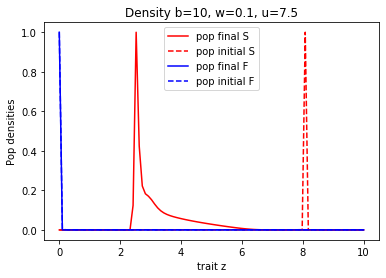

In [50]:
# Initial and final distributions of S and F
plt.plot(Z, S[-1,:]/max(S[-1,:]), color ='red', label = 'pop final S')
plt.xlabel('trait z')
plt.plot(Z, S[0,:]/max(S[0,:]), 'r--', label = 'pop initial S')
plt.plot(Z, F[-1,:]/max(F[-1,:]), color ='blue', label = 'pop final F')
plt.xlabel('trait z')
plt.plot(Z, F[0,:]/max(F[0,:]),  'b--', label = 'pop initial F')
plt.ylabel('Pop densities')
valb = str(b)
valw = str(w)
valu = str(u)
titre = ('Density b=' + valb + ', w=' + valw + ', u=' + valu)
plt.title(titre)
plt.legend()
plt.legend()

In [ ]:
#Total populations size
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(N),(sum(np.transpose(S))*zb/NX), label= 'pop S', c='r')
ax.plot(range(N), (sum(np.transpose(F))*zb/NX), label= 'pop F', c='blue')
plt.xlabel('time')
plt.ylabel('population size')
plt.legend()


In [35]:
II = []
for i in np.arange(len(S[18000,:])):
    for k in np.arange(int(S[18000,i])):
        II.append(Z[i])


In [ ]:
# Evolution of mean traits of S and F
plt.figure(1)
plt.plot(range(N),sum(np.transpose(Z*S))/sum(np.transpose(S)), label= 'trait S', c='r')
plt.plot(range(N),sum(np.transpose(Z*F))/sum(np.transpose(F)), label= 'trait F', c='b')
plt.legend()
plt.xlabel('time')
plt.ylabel('trait moyen')

In [50]:
# Evolution of median traits of S and F
medianS = np.zeros(N)
medianF = np.zeros(N)

for j in range(N) : 
    II = []
    II2 = []
    for i in np.arange(len(S[j,:])):
        for k in np.arange(int(S[j,i])):
            II.append(Z[i])
        for l in np.arange(int(F[j,i])):
            II2.append(Z[i])
    medianS[j] = np.median(II)
    medianF[j] = np.median(II2)
    
plt.plot(range(N), medianS)
plt.plot(range(N), medianF)

In [12]:
#Emergence of phenotypes through time
TRAITS = np.zeros((NX,N))
TRAITF = np.zeros((NX,N))

for j in range(N) : 
    for i in range(30) : 
        TRAITS[5*i+1:5*i+5,j] = sum(S[j,5*i+1:5*i+5])/10.
        TRAITF[5*i+1:5*i+5,j] = sum(F[j,5*i:5*i+5])/10.
        
palette = copy(plt.get_cmap('Spectral'))
palette.set_under('white',1.0)

levels = np.arange(0, max(map(max, TRAITS)), 10)
levels[0] = 1

levelsF = np.arange(0, max(map(max, TRAITF)), 10)
levelsF[0] = 0.01

#S
norm = colors.BoundaryNorm(levels, ncolors=palette.N)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(TRAITS, cmap=palette,norm=norm,extent =[ 0,N,10,0],aspect='auto')
ax.autoscale(False)
plt.xlabel('time')
plt.ylabel('trait zs')
plt.title('Presence of traits through time')
plt.colorbar()

#F
normF = colors.BoundaryNorm(levelsF, ncolors=palette.N)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(TRAITF, cmap=palette,norm=normF,extent =[ 0,N,10,0],aspect='auto')
plt.autoscale(False)
plt.xlabel('time')
plt.ylabel('trait zf')
plt.title('Presence of traits through time')
plt.colorbar(im)